In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [142]:
# main dataset은 동별 일별 데이터 -> 클러스터링 할 때에는 동별로 평균내어 진행
df = pd.read_csv("../data/main_df2.csv", index_col=0)
grouped_df = df.groupby('dong').mean()
grouped_df.describe()

,date_cd,temp,hum,redust,pm10,pm25,o3,no2,co,so2,buspop,stops,consts
count,1.210000e+02,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,2.022161e+07,20.170477,57.938834,34.905842,32.989940,17.805470,0.031926,0.020448,0.419913,0.002854,25047.122729,61.793388,28.907127
std,1.097984e+03,4.050798,7.118418,24.734561,7.274902,4.167379,0.003967,0.003898,0.060436,0.000313,16384.523022,45.088971,8.656470
min,2.022026e+07,5.000000,45.900000,5.000000,20.666667,9.500000,0.020500,0.012200,0.271429,0.002250,4214.333333,4.000000,8.500000
25%,2.022081e+07,17.000000,52.375000,18.000000,29.000000,15.000000,0.028923,0.017438,0.366667,0.002600,12609.428571,26.000000,24.230769
50%,2.022086e+07,20.714286,57.272727,27.857143,31.500000,17.909091,0.031538,0.020429,0.410000,0.002846,20117.333333,49.000000,28.727273
75%,2.022240e+07,23.600000,61.250000,47.307692,36.500000,20.357143,0.034500,0.022600,0.460000,0.003100,36214.142857,94.000000,35.538462
max,2.022500e+07,27.000000,76.571429,158.727273,56.300000,26.833333,0.041167,0.031167,0.650000,0.003667,75157.500000,190.000000,48.300000


In [143]:
# temp, hum의 경우 서울 내에서 평균을 냈을 때 많은 차이가 나지 않을 것이기에 제외
# 대기오염지표, 공사장 수는 구 단위이므로 제외함
feature=['redust', 'buspop', 'stops']
X_train=grouped_df[feature].values

In [144]:
# outlier등 처리를 위함
X_train = np.log1p(X_train)

In [145]:
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X_train)

k-means

In [146]:
clusters = []
kmeans_silhouette_scores = []
inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    clusters.append(k)
    inertia.append(kmeans.inertia_)

    score = silhouette_score(X_scaled, kmeans.labels_)
    kmeans_silhouette_scores.append(score)
    
kmeans_silhouette_scores

[0.33464957385386745,
 0.3102970490245171,
 0.2889823123924558,
 0.30102090610069876,
 0.30660459573569976,
 0.29472372555236165,
 0.3110107653428419,
 0.30071585404820156,
 0.3083453790125078]

In [147]:
k_result = pd.DataFrame({"n_clusters": clusters, "sil_scores":kmeans_silhouette_scores})
k_result.sort_values('sil_scores', ascending=False).head()

,n_clusters,sil_scores
0,2,0.334650
6,8,0.311011
1,3,0.310297
8,10,0.308345
4,6,0.306605


Text(0.5, 1.0, 'K-Means Inertia')

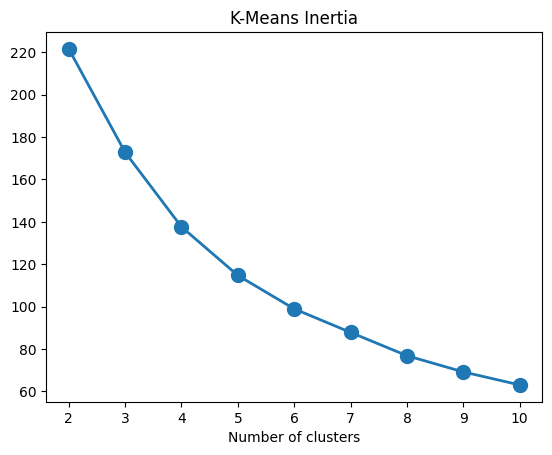

In [148]:
plt.plot(range(2,11), inertia, marker='o', lw=2, ms=10)
plt.xlabel("Number of clusters")
plt.title("K-Means Inertia")

In [149]:
# 실루엣 스코어와 엘보우 차트를 함께 고려하여,
# 실루엣 스코어가 높고, 꺾이는 듯한 지점인 k=6로 설정
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=6, random_state=42)

In [150]:
scaler.inverse_transform(kmeans.cluster_centers_)
assignments_X_train_scaled_k = kmeans.labels_
print(assignments_X_train_scaled_k)

[4 1 5 0 5 1 1 0 4 5 1 0 2 4 3 0 4 4 4 2 2 4 4 4 4 4 0 1 1 4 2 5 2 4 2 1 0
 0 1 5 2 5 1 4 0 0 3 5 0 2 0 0 3 0 1 2 2 2 1 4 5 4 5 5 0 1 4 2 1 0 0 5 0 1
 4 0 4 4 1 1 2 2 1 0 1 0 0 4 1 1 2 0 1 2 5 1 3 2 5 4 2 4 2 0 0 4 2 1 4 2 4
 1 4 0 0 5 1 3 3 4 2]


In [151]:
grouped_df['cluster'] = assignments_X_train_scaled_k

In [152]:
grouped_df.groupby('cluster')[feature].agg(['count', 'mean'])

redust            buspop               stops            
         count       mean  count          mean count        mean
cluster                                                         
0           26  20.092103     26  42068.417287    26  100.692308
1           25  45.797502     25  10449.312944    25   21.720000
2           22  48.871573     22  21362.123111    22   61.727273
3            6  11.100000      6   6266.955556     6   12.000000
4           28  16.968141     28  20707.509389    28   36.750000
5           14  67.099433     14  42022.248032    14  132.642857

### 클러스터 정리
(버스승하차 인구 ~= 유동인구)
* 0번 그룹 - 재비산먼지 낮음 / 유동인구 많음 / 버스정류장 많음
* 1번 그룹 - 재비산먼지 보통 / 유동인구 적음 / 버스정류장 적음
* 2번 그룹 - 재비산먼지 보통 / 유동인구 보통 / 버스정류장 보통
* 3번 그룹 - 재비산먼지 낮음 / 유동인구 적음 / 버스정류장 적음
* 4번 그룹 - 재비산먼지 낮음 / 유동인구 보통 / 버스정류장 적음
* 5번 그룹 - 재비산먼지 높음 / 유동인구 많음 / 버스정류장 많음

### 미세먼지 프리존 버스정류장 설치 전략 수립(우선순위)
1. 5번 그룹
2. 2번 그룹
3. 0번 그룹(재비산먼지는 낮지만, 유동인구(=누릴 수 있는 사람)가 많기 때문)
4. 1번 그룹
5. 4번 그룹
6. 3번 그룹